# Analisis de grupo de whatsapp

 <h3>Cargar conversarion exportada en un archivo de texto.</h3>

In [1]:
import pandas as pd
import re
from datetime import datetime
import unicodedata
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import numpy as np 
from PIL import Image, ImageOps
# Ruta del archivo exportado
archivo = "_chat.txt"

# Leer todo el archivo como texto
with open(archivo, "r", encoding="utf-8") as f:
    lineas = f.readlines()


In [2]:
print(f"Total de líneas leídas: {len(lineas)}") #confirmamos que lea el archivo

Total de líneas leídas: 21795


 ## Ingesta y limpieza de datos.

In [6]:
patron = re.compile(
    r'^\[?(\d{1,2}/\d{1,2}/\d{2,4}), (\d{1,2}:\d{2}(?::\d{2})?(?:\s*[ap]\.?m\.?)?)\]?\s(.*?): (.*)'
)

mensajes = []
mensaje_actual = None

for linea in lineas:
    linea = unicodedata.normalize('NFKC', linea)
    linea = linea.replace('\u202f', ' ').replace('\u200e', '').strip()

    if not linea:
        continue

    match = patron.match(linea)
    if match:
        if mensaje_actual:
            mensajes.append(mensaje_actual)
        fecha, hora, usuario, texto = match.groups()
        mensaje_actual = {
            'fecha': fecha.strip(),
            'hora': hora.strip(),
            'usuario': usuario.strip(),
            'mensaje': texto.strip()
        }
    else:
        # línea que continúa un mensaje anterior
        if mensaje_actual:
            mensaje_actual['mensaje'] += '\n' + linea

if mensaje_actual:
    mensajes.append(mensaje_actual)


# convertir a DataFrame
df = pd.DataFrame(mensajes)

# Limpiar la hora 
def limpiar_hora(h):
    if pd.isna(h):
        return None
    h = h.replace('\u202f', ' ')   # espacio fino
    h = h.replace('.', '')         # eliminar puntos
    h = h.replace('am', 'AM').replace('pm', 'PM')
    h = h.strip()
    for fmt in ['%I:%M:%S %p', '%I:%M %p']:
        try:
            return datetime.strptime(h, fmt).time()
        except ValueError:
            continue
    return None

# aplicar limpieza
df['hora'] = df['hora'].apply(limpiar_hora)
# convertir fecha
df['fecha'] = pd.to_datetime(df['fecha'],  format='%m/%d/%y',errors='coerce') 

# asegurarse que texto sea string
df['mensaje'] = df['mensaje'].astype(str)

# en mensaje tambien se filtran nombres de los usuarios por eso se cambia a anonimo
df['mensaje'] = df.apply(lambda row: re.sub(
    re.escape(row['usuario']), 'Pokemon', row['mensaje'], flags=re.IGNORECASE
), axis=1)

# si hay numeros de telefonos los cambia a anonimos
df['mensaje'] = df['mensaje'].apply(lambda x: re.sub(r'\+?\d[\d\s\-]{6,}\d', '[numero telefonico anonimo]', x))

<p> Usuarios anonimos </p>

In [9]:
# hacemos anonimos a los usuarios con mombres de pokemon 
pokemon_nombres = [
    'Mewtwo', 'Gengar', 'Charmander', 'Eevee', 'Eevee', 'Jigglypuff', 
    'Meowth', 'Psyduck', 'Snorlax', 'Mew', 'Mewtwo', 'Gengar', 'Vaporeon'
] 

In [11]:
#  a los 4 usuarios principales por que uno de ellos es meta, otro es un usuario que eliminamos al crear el grupo
top_usuarios = df['usuario'].value_counts().head(4).index.tolist()
df = df[df['usuario'].isin(top_usuarios)]
usuarios_unicos = df['usuario'].unique()

# Asignar un Pokémon aleatorio a cada usuario
mapa_usuarios = {usuario: pokemon_nombres[i % len(pokemon_nombres)] for i, usuario in enumerate(usuarios_unicos)}
df['usuario'] = df['usuario'].map(mapa_usuarios)

In [13]:
# usamos regex para "imagen omitida, audio omitido ... etx "
patrones_tipos = {
    'imagen': r'imagen omitid[ao]|<.*imagen.*omitid[ao]>|image omitted|foto omitida',
    'video': r'video omitid[ao]|<.*video.*omitid[ao]>|video omitted',
    'audio': r'audio omitid[ao]|<.*audio.*omitid[ao]>|audio omitted|PTT-\d+',
    'sticker': r'sticker omitid[ao]|<.*sticker.*omitid[ao]>',
    'documento': r'documento omitid[ao]|<.*documento.*omitid[ao]>|document omitted|.*\.pdf|.*\.docx?|.*\.xlsx?'
}
# iteramos  regex, cada tipo y oatron en cada elemento
patrones_compilados = {tipo: re.compile(patron, re.IGNORECASE) for tipo, patron in patrones_tipos.items()}

# Función para clasificar el tipo de mensaje
def tipo_mensaje(texto):
    if not isinstance(texto, str):
        return 'texto'
    for tipo, patron in patrones_compilados.items():
        if patron.search(texto):
            return tipo
    return 'texto'

# Aplicar la función al DataFrame
df['tipo'] = df['mensaje'].apply(tipo_mensaje)

# Contar número de palabras (solo si es texto)
df['num_palabras'] = df.apply(
    lambda x: len(x['mensaje'].split()) if x['tipo'] == 'texto' and isinstance(x['mensaje'], str) else 0,
    axis=1
)

# Mostrar primeros resultados
df.head(10)


,fecha,hora,usuario,mensaje,tipo,num_palabras
3,2022-08-28,17:53:29,Mewtwo,cambió la imagen de este grupo.,texto,6
4,2022-08-28,17:53:30,Mewtwo,"cambió el nombre del grupo a ""las tilinas"".",texto,8
5,2022-08-28,17:53:41,Mewtwo,Holii,texto,1
6,2022-08-28,17:54:09,Gengar,hola mis tilnes fav 😍😘,texto,5
7,2022-08-28,17:54:26,Mewtwo,sticker omitido,sticker,0
8,2022-08-28,18:55:13,Charmander,Holiiisss,texto,1
9,2022-08-28,18:57:01,Mewtwo,Nos vemos mañanaa?,texto,3
10,2022-08-28,18:57:06,Mewtwo,Salgo a las 7 del workk,texto,6
11,2022-08-28,18:57:24,Mewtwo,Le decia al joel que el martes pero a las 8:30...,texto,18
12,2022-08-28,18:57:54,Charmander,Como una bebe?,texto,3


 <h3>Análisis exploratorio de datos.</h3>

In [16]:
# Número total de mensajes
total_mensajes = len(df)

# Número de usuarios únicos
num_usuarios = df['usuario'].nunique()

# Promedio de mensajes por usuario
promedio_por_usuario = df.groupby('usuario')['mensaje'].count().mean()

print(f"Total de mensajes: {total_mensajes}")
print(f"Número de usuarios: {num_usuarios}")
print(f"Promedio de mensajes por usuario: {promedio_por_usuario:.2f}")

Total de mensajes: 21567
Número de usuarios: 4
Promedio de mensajes por usuario: 5391.75


### Una gráfica de barras que muestre quienes son los usuarios más activos (¿Quienes son los que más escriben?)

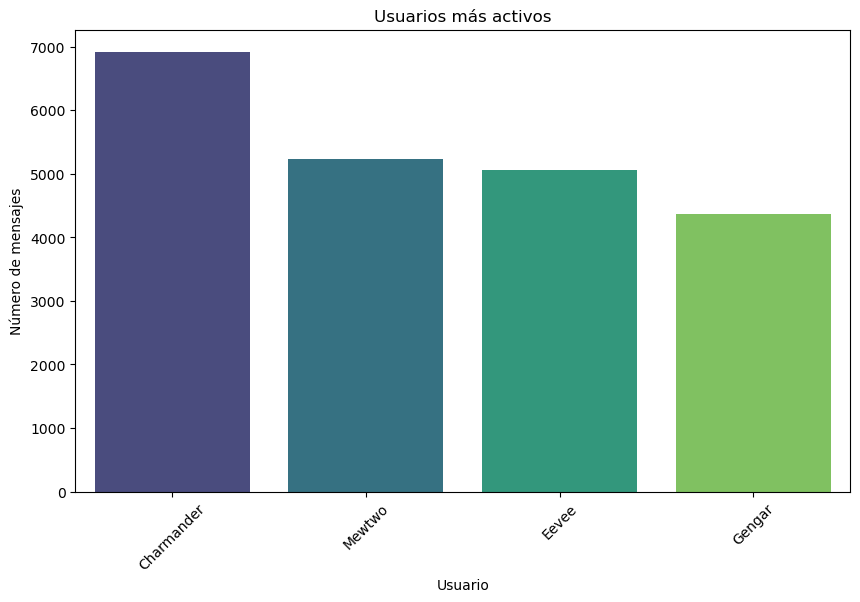

In [19]:

# Contar mensajes por usuario
mensajes_por_usuario = df.groupby('usuario')['mensaje'].count().sort_values(ascending=False).reset_index()
mensajes_por_usuario.columns = ['usuario', 'num_mensajes']

plt.figure(figsize=(10,6))
sns.barplot(
    data=mensajes_por_usuario,
    x='usuario',
    y='num_mensajes',
    hue='usuario',
    palette='viridis',
    legend=False
)
plt.xticks(rotation=45)
plt.ylabel('Número de mensajes')
plt.xlabel('Usuario')
plt.title('Usuarios más activos')
plt.show()

### distribucion de mensajes a lo largo del dia 

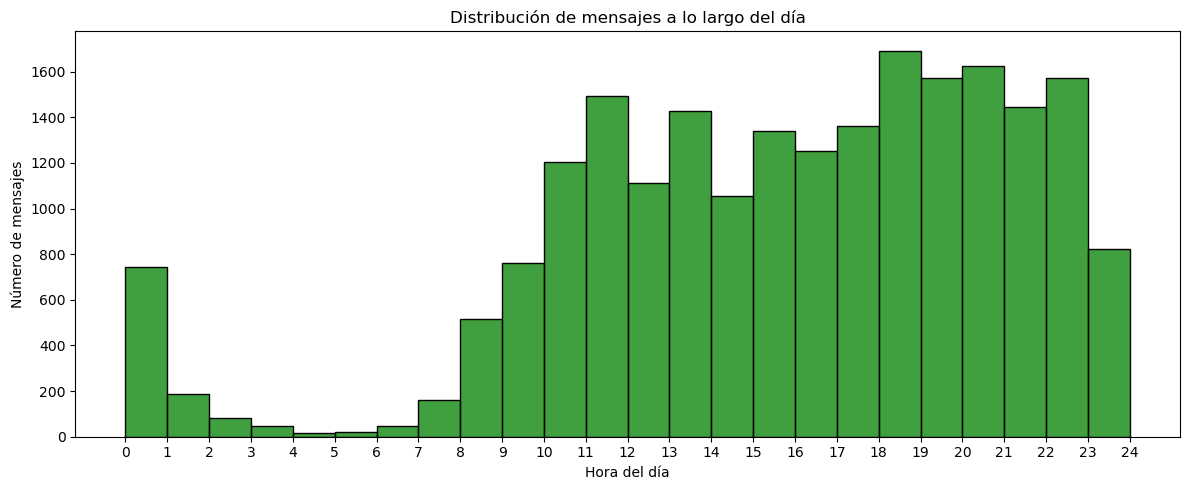

In [22]:
# Extraer hora en formato 24h
df['hora_float'] = df['hora'].apply(lambda x: x.hour + x.minute/60 if pd.notnull(x) else None)

# Crear el histograma
plt.figure(figsize=(12,5))
sns.histplot(df['hora_float'], bins=np.arange(0,25,1), color='green', kde=False)
plt.xticks(range(0,25))
plt.xlabel('Hora del día')
plt.ylabel('Número de mensajes')
plt.title('Distribución de mensajes a lo largo del día')
plt.tight_layout()
plt.show()

### Cantidad de mensajes por día de la semana (¿Qué días son los más activos?)

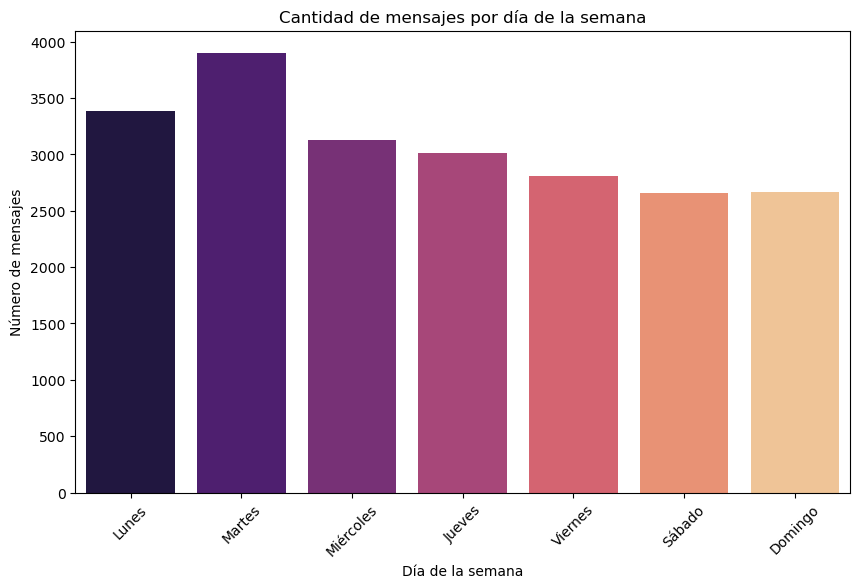

In [25]:
# Día de la semana (0=lunes, 6=domingo)
dias = {
    'Monday': 'Lunes',
    'Tuesday': 'Martes',
    'Wednesday': 'Miércoles',
    'Thursday': 'Jueves',
    'Friday': 'Viernes',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
}

df['dia_semana'] = df['fecha'].dt.day_name().map(dias)
orden_dias = ['Lunes','Martes','Miércoles','Jueves','Viernes','Sábado','Domingo']
mensajes_por_dia = df.groupby('dia_semana')['mensaje'].count().reindex(orden_dias)

plt.figure(figsize=(10,6))
sns.barplot(x=mensajes_por_dia.index, y=mensajes_por_dia.values, hue=mensajes_por_dia.index, palette='magma', legend=False)
plt.xticks(rotation=45)
plt.ylabel('Número de mensajes')
plt.xlabel('Día de la semana')
plt.title('Cantidad de mensajes por día de la semana')
plt.show()

In [27]:
## mensajes por usuario

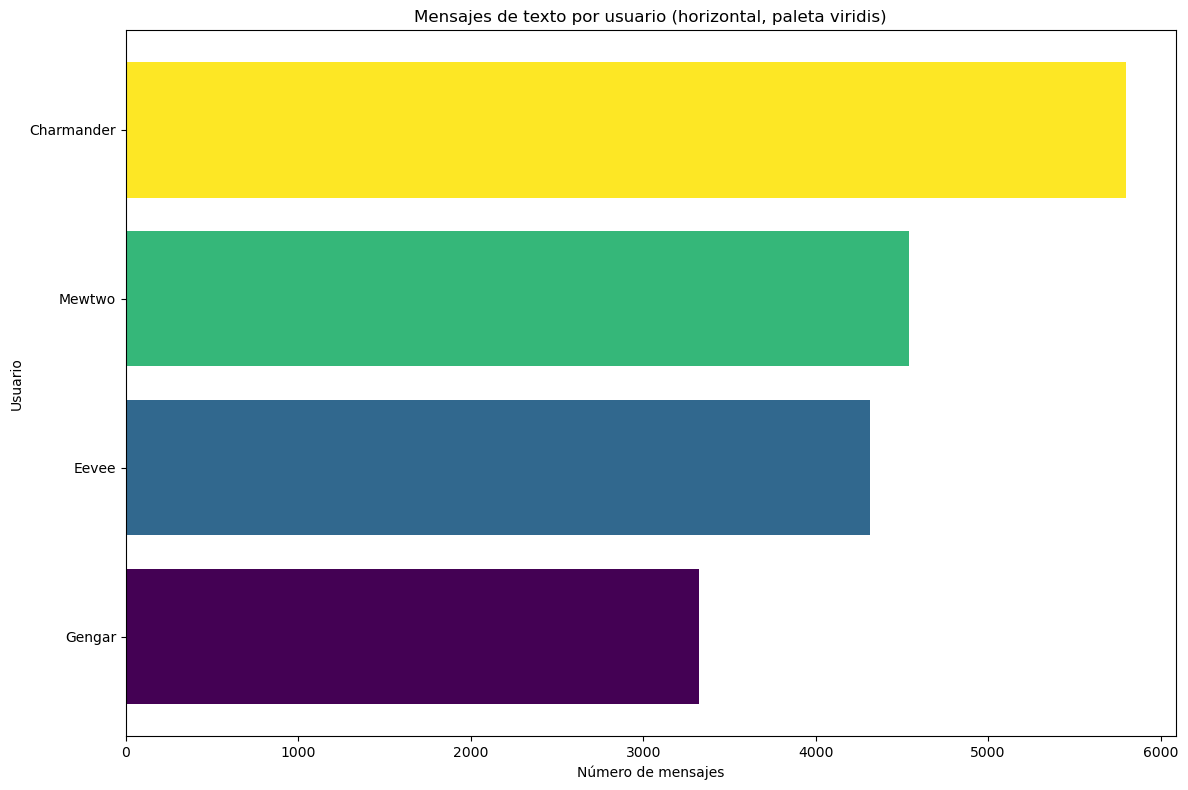

In [29]:
# Filtrar solo mensajes de tipo 'texto'
df_solo_texto = df[df['tipo'] == 'texto']

# Contar mensajes por usuario
mensajes_por_usuario = df_solo_texto.groupby('usuario')['mensaje'].count().sort_values(ascending=True).reset_index()
mensajes_por_usuario.rename(columns={'mensaje':'num_mensajes'}, inplace=True)

# Crear colores usando la paleta viridis
n = len(mensajes_por_usuario)
colores = plt.cm.viridis(np.linspace(0, 1, n))

# Gráfico horizontal
plt.figure(figsize=(12,8))
plt.barh(
    mensajes_por_usuario['usuario'],
    mensajes_por_usuario['num_mensajes'],
    color=colores
)

plt.xlabel('Número de mensajes')
plt.ylabel('Usuario')
plt.title('Mensajes de texto por usuario (horizontal, paleta viridis)')
plt.tight_layout()
plt.show()

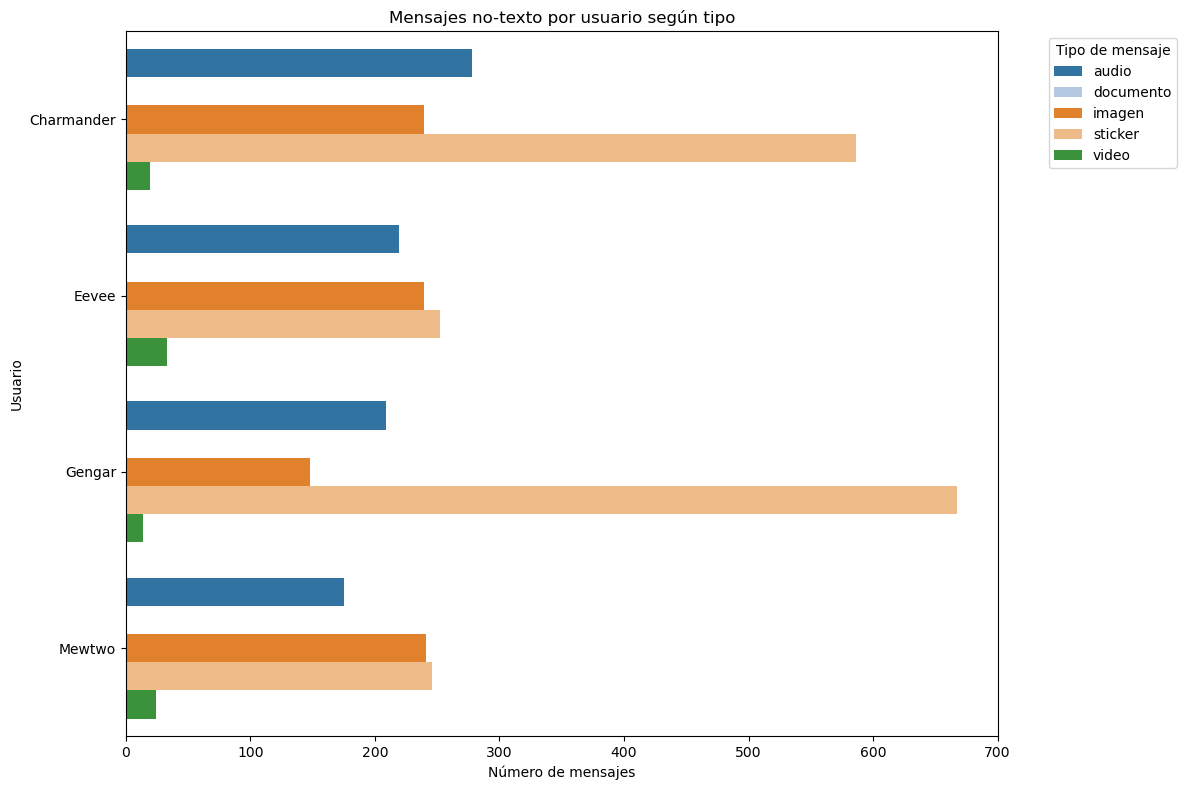

In [31]:
# Filtrar para quitar los mensajes de tipo 'texto'
df_sin_texto = df[df['tipo'] != 'texto']

# Contar mensajes por usuario y tipo
mensajes_tipo_usuario = df_sin_texto.groupby(['usuario', 'tipo'])['mensaje'].count().reset_index()
mensajes_tipo_usuario.rename(columns={'mensaje':'num_mensajes'}, inplace=True)

# Gráfico de barras horizontal
plt.figure(figsize=(12,8))
sns.barplot(
    data=mensajes_tipo_usuario,
    y='usuario',
    x='num_mensajes',
    hue='tipo',
    palette='tab20'
)

plt.xlabel('Número de mensajes')
plt.ylabel('Usuario')
plt.title('Mensajes no-texto por usuario según tipo')
plt.legend(title='Tipo de mensaje', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [32]:
#cantidad de mensajes por tipo
conteo_tipos = df['tipo'].value_counts()
print("Cantidad de mensajes por tipo:")
print(conteo_tipos)


Cantidad de mensajes por tipo:
tipo
texto        17977
sticker       1751
audio          881
imagen         867
video           90
documento        1
Name: count, dtype: int64


In [35]:
# Contar cantidad de mensajes por usuario y tipo
mensajes_por_usuario_tipo = df.groupby(['usuario', 'tipo'])['mensaje'].count().reset_index()
mensajes_por_usuario_tipo.rename(columns={'mensaje':'num_mensajes'}, inplace=True)

# Pivotar para que cada tipo sea columna
df_pivot = mensajes_por_usuario_tipo.pivot(index='usuario', columns='tipo', values='num_mensajes').fillna(0)
df_pivot


tipo,audio,documento,imagen,sticker,texto,video
usuario,,,,,,
Charmander,278.0,1.0,239.0,586.0,5798.0,19.0
Eevee,219.0,0.0,239.0,252.0,4313.0,33.0
Gengar,209.0,0.0,148.0,667.0,3324.0,14.0
Mewtwo,175.0,0.0,241.0,246.0,4542.0,24.0


## Nube de palabras sin las stopwords 

In [38]:
#Preparar el texto
texto_completo = " ".join(mensaje for mensaje in df.mensaje)

# eliminar risas
texto_completo = re.sub(r'\b(?:[jae]{2,}\s*)+\b', '', texto_completo, flags=re.IGNORECASE)

# Leer palabras propias desde archivo que ingoraremos al subir en git ya que contiene palabras que deben quedar anonimas
with open("palabras_propias.txt", "r", encoding="utf-8") as f:
    palabras_propias = set(line.strip() for line in f if line.strip())

nlp = spacy.load('es_core_news_md')
stopwords_de_spacy = nlp.Defaults.stop_words
stopwords_combinadas = stopwords_de_spacy.union(palabras_propias)


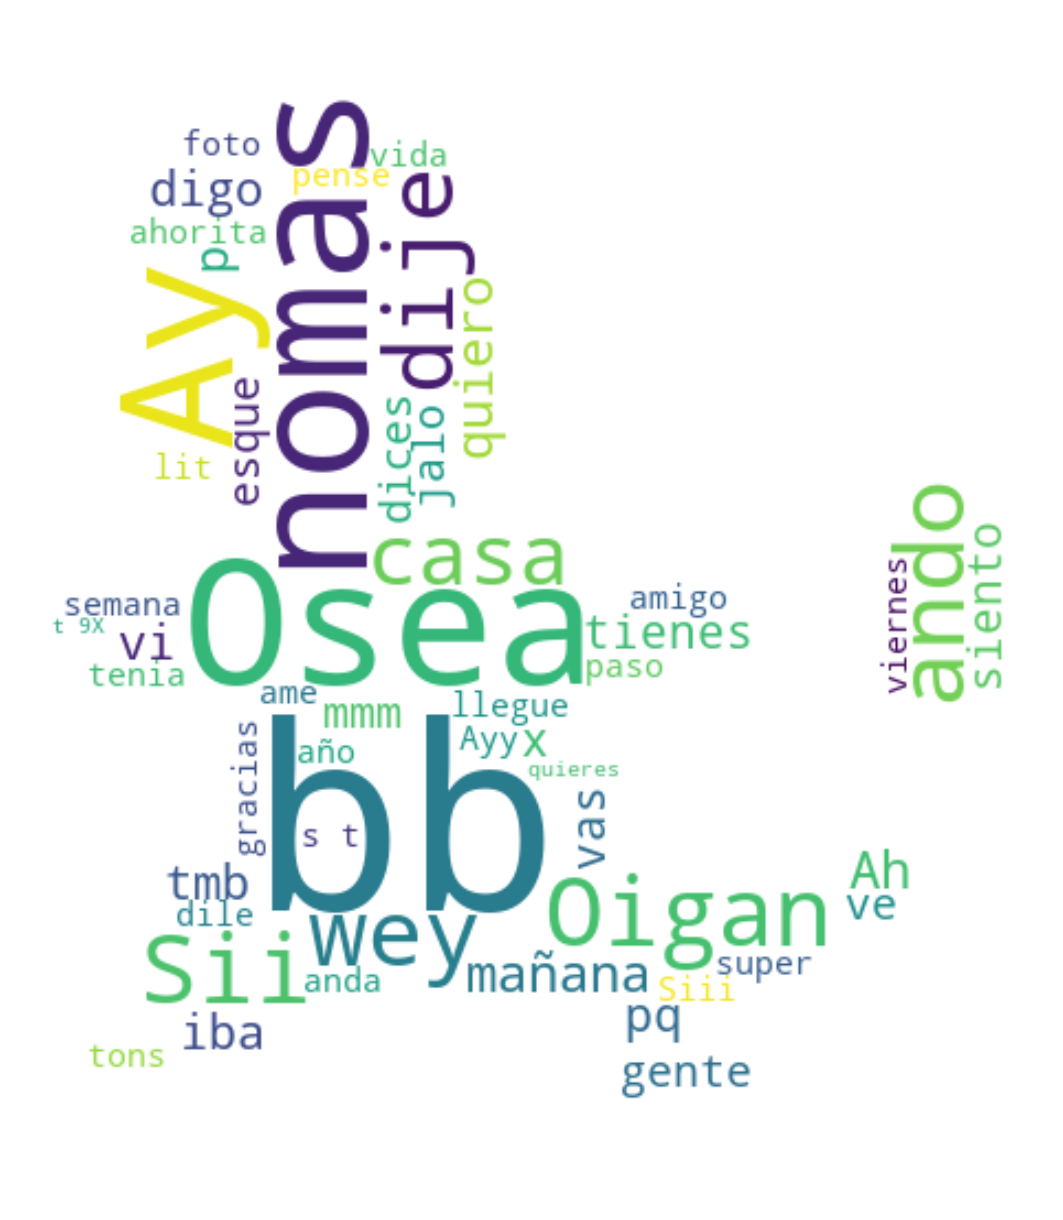

In [44]:
try:
    img = Image.open("charmander.png").convert('L')
    mask = np.array(img)
except FileNotFoundError:
    print("Error: No se encontró la imagen 'charmander.png'.")
    mask = None
    
# Generar la nube de palabras
if mask is not None:
    wordcloud = WordCloud(
        stopwords=stopwords_combinadas,
        mask=mask,
        background_color='white',
        max_words=200,
        min_font_size=10
    ).generate(texto_completo)

    plt.figure(figsize=(12, 12))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

In [50]:
frecuencias = wordcloud.words_
frecuencias_df = pd.DataFrame(frecuencias.items(), columns=['Palabra', 'Frecuencia'])
frecuencias_df['Frecuencia (%)'] = frecuencias_df['Frecuencia'] * 100
frecuencias_df = frecuencias_df.sort_values(by='Frecuencia', ascending=False)


frecuencias_df.head(10)

,Palabra,Frecuencia,Frecuencia (%)
0,bb,1.000000,100.000000
1,Osea,0.356808,35.680751
2,nomas,0.323944,32.394366
3,Ay,0.300469,30.046948
4,Oigan,0.226917,22.691706
5,Sii,0.223787,22.378717
6,dije,0.212833,21.283255
7,wey,0.211268,21.126761
8,ando,0.209703,20.970266
9,casa,0.205008,20.500782
